In [1]:
import os
import pandas as pd
from anndata import read_h5ad
import scanpy as sc
import scregseg
import matplotlib.pyplot as plt
from scregseg.visualize import plot_fragmentsize

Using TensorFlow backend.
/home/wkopp/anaconda3/envs/scregseg2/lib/python3.7/site-packages/numpydoc/docscrape.py:418: UserWarning: Unknown section Return
  warn(msg)


In this tutorial we show how to

    1. employ Scregseg to segment the genome based on single-cell ATAC-seq data.
    2. evaluate the initial Scregseg results and the state.
    3. Export regions associated with putative informative states for downstream analysis tasks.

# Scregseg on single-cell ATAC-seq data

Scregseg implements an HMM-based segmentation model based on Dirichlet-Multinomial emission probabilities
which allows to classify the genome in states exhibiting distinct cross-cell accessibility profiles. That is, the states may represent regions that are specifically accessible in subpopulations of cells, across all cells or merely reflect
genomic background signal.

![Scregseg scheme](scregseg_fi_scheme_v2.svg)

We shall use the 10x Genomics datasets that we have prepared in tutorial 01.

### Model fitting

The HMM-model for genome segmentation can be fitted using `scregseg fit_segment`,
which fits the parameters of the HMM and subsequently performs state calling across the genome.

To this end, Scregseg requires a count matrix of genome-wide bins by cells.
In the example, we shall use a 30 state model and run the model on 30 cores to speedup the parameter fitting step.

The model parameters and state calling results as well as some statistics about the states
are saved in the directory `scregseg_fi`

In [2]:
!scregseg fit_segment --counts filtered_countmatrix.h5ad \
    --regions tile1kb.bed \
    --storage scregseg_fi \
    --randomseed 32 --n_jobs 30 --nstates 30

         1  -636550017.7295             +nan
         2  -629475961.5475    +7074056.1820
         3  -626012124.0303    +3463837.5172
         4  -624906670.4660    +1105453.5643
         5  -624366916.2896     +539754.1764
         6  -623887116.0201     +479800.2695
         7  -623385016.1783     +502099.8418
         8  -622897134.9811     +487881.1972
         9  -622507140.4222     +389994.5589
        10  -622243340.3021     +263800.1201
        11  -622074280.8414     +169059.4607
        12  -621961717.4307     +112563.4107
        13  -621882587.5397      +79129.8910
        14  -621822657.4558      +59930.0839
        15  -621777650.1039      +45007.3519
        16  -621744752.8702      +32897.2338
        17  -621719815.8360      +24937.0342
        18  -621701026.4775      +18789.3585
        19  -621686894.7637      +14131.7138
        20  -621675997.0498      +10897.7139
        21  -621667181.3386       +8815.7112
        22  -621659785.5466       +7395.7920
        23

When fitting an HMM on single-cell resolution data, we find that usually 
running a 30-50 state model works well.

This will result in about 10-20 informative states
leaving the remaining states as background.
We find that increasing the number of states will usually 
result in further splitting up background states. On the other hand,
increasing the state number of the model appears to less frequently refine the informative states.
That is, the number of informative states remains similar across different models with different state numbers.

### Exploring the model results

After having fitted a model and called states, we can explore some initial statistics about the states. This allows us to get a sense as to which states 
might be putatively informative (e.g. describe cell type specific regulatory regions) 
and which states might merely reflect genomic background.

Load the Scregseg results:

In [2]:
model = scregseg.Scregseg.load(os.path.join('scregseg_fi', 'dirmulhmm'))

The first indication about the likely functional relevance of a states is given by the state frequency.
That is, how much of the genome is covered by a give state.

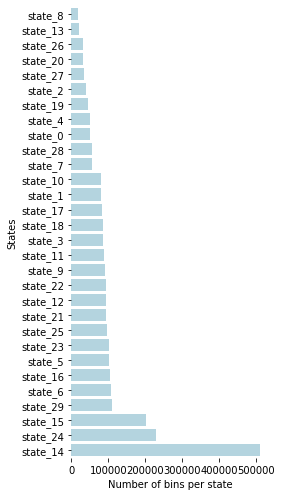

In [3]:
fig, ax =  plt.subplots(figsize=(4,7))
model.plot_state_frequency(ax=ax)
plt.tight_layout()

While some states cover a large fraction of the genome (e.g. state_14),
others are relatively rare (e.g. state_8).
In general, rare states are more likely to reflect functional regions, including
cell-type specific regulatory regions, while abundant states are more likely to reflect
genomic background signal.

Different states may be associated with differing read depths.

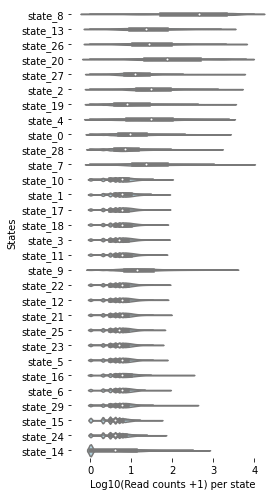

In [4]:
fig, ax =  plt.subplots(figsize=(4,7))
model.plot_readdepth(ax=ax)
plt.tight_layout()

It appears that rare states tend to exhibit higher read counts across cells, which further supports their functional relevance.

In [5]:
adata = read_h5ad('filtered_countmatrix.h5ad')

Next, we could explore the cell-state relationship. 
To this end, we ask whether a given state is enriched in the 
accessible portion of a given cell
relative to the overall state frequencies across the genome.

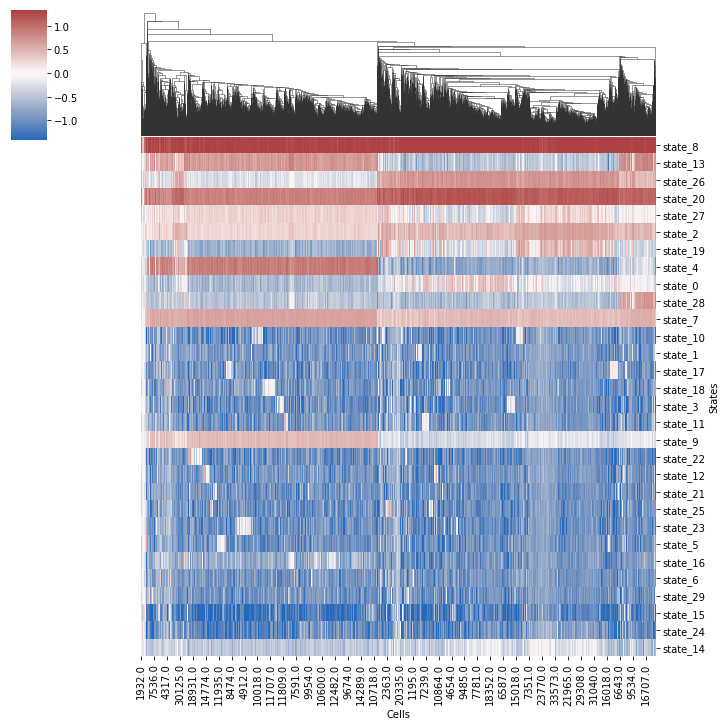

In [6]:
_ = model.plot_cell_state_association(adata)

From this we can make several interesting observations:

1. There are usually one or more states that are overrepresented in all (or most) cells. Such states represent constitutively accessible regions. In the example, states 8 and 20 reflect consitutive accessibility.
These are usually associated with gene promoter regions.
2. Some states are enriched only in a subpopulation of the cells. These reflect cell-type specific accessibility e.g. of regulatory regions. For example, state 13 and 4.
3. Some states don't seem to be specifically enriched in any subpopulation. These states are likely background states. For example, state 14.

Finally, we can explore the state-specific fragment length distribution.

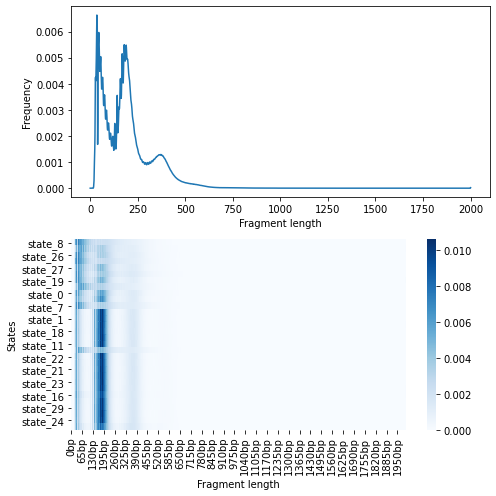

In [7]:
fig, axes=plt.subplots(2, figsize=(7,7))
plot_fragmentsize(adata, ax=axes[0])
model.plot_fragmentsize(adata, ax=axes[1], cmap="Blues")
plt.tight_layout()


We observe that putative functional (i.e. rare states) and background states tend to 
show distinct fragment length distribution profiles.
Background states tend to exhibit a depletion of short fragment (<140bp), 
while putative functional regions are usually enriched for short fragment sizes.
Short fragment length are suggestive of nucleosome free regions, which are characteristic
of regulatory regions such as promoters or enhancers.
On the other hand, long fragment lengths (>140bp) reflect nucleosome spanning reads.

Taken together, these observations suggest that likely functional 
states tend to be 1. rare, 2. exhibit higher read depth (but this will depend on the cell population size as well), 
3. tend to be enriched in subpopulations of the cells or all cells
and 4. enriched for short fragment lengths that indicate nucleosome free regions.

### Export putative informative regions

One way to make use of segmentation results at this point
would be to extract regions associated with putative informative states
and use them as features for the subsequent downstream processing, including dimensionality reduction.

As a simple rule of thumb, we could extract regions associated with the X rarest states. In this example, we might want to consider the eleven rarest states.

In [5]:
!scregseg seg_to_bed \
          --storage scregseg_fi \
          --threshold 0.9 \
          --nstates 11 \
          --nregsperstate 5000 \
          --no_bookended_merging \
          --counts filtered_countmatrix.h5ad \
          --output informative_11_rarest_states.bed

/home/wkopp/anaconda3/envs/scregseg2/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'chrom' as categorical
... storing 'name' as categorical
... storing 'strand' as categorical
... storing 'itemRbg' as categorical


We recommend to use a posterior probability threshold (using --threshold) such that only confident state calls with probability of at least 0.9 are considered.
Additionally, we find that it is usually sufficient to just use a subset 
of the regions for a give state (e.g. 5000 regions as determined by --nregsperstate) due to the inherent redundancy within a state.

Alternatively, it is possible to choose the putative informative states manually. In this example,
we have added state_9, since it also exhibits some hallmarks of likely functional regions even though it is not among the rarest states.

In [6]:
!scregseg seg_to_bed \
          --storage scregseg_fi \
          --threshold 0.9 \
          --method manualselect \
          --statenames state_8 state_13 state_26 state_20 state_27 state_2 state_19 state_4 state_0 state_7 state_9 \
          --nregsperstate 5000 \
          --no_bookended_merging \
          --counts filtered_countmatrix.h5ad \
          --output informative_manual_states.bed

/home/wkopp/anaconda3/envs/scregseg2/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'chrom' as categorical
... storing 'name' as categorical
... storing 'strand' as categorical
... storing 'itemRbg' as categorical
